In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import reshape
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score, silhouette_score, homogeneity_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import learning_curve


def balance(data): #sample it down to 1200 to balance out
    zero = data[data['Potability']==0] #has 1200
    one = data[data['Potability']==1] #has 811
    resampledData = resample(one, n_samples=1200)
    updatedData = shuffle(pd.concat([zero, resampledData]))
    return updatedData

def variableClean(data):
    indepVariable = data.drop('Potability', axis=1).copy()
    depVariable = data['Potability'].copy()
    scal = StandardScaler()
    features = indepVariable.columns
    indepVariable[features] = scal.fit_transform(indepVariable[features])
    return indepVariable, depVariable

def normalizeFeatures(dataX1, dataX2):
    preprocMinMaxScaler = preprocessing.MinMaxScaler()
    dataX1 = preprocMinMaxScaler.fit_transform(dataX1)
    dataX2 = preprocMinMaxScaler.fit_transform(dataX2)
    return [dataX1, dataX2]

def plotSSE(clusters, dataX):
    sse = {}
    for cluster in clusters:
        kMeans = KMeans(n_clusters=cluster, max_iter=700).fit(dataX)
        sse[cluster] = kMeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("SSE vs Clusters")
    plt.xlabel("Cluster #s")
    plt.ylabel("Sum of Squared Errors")
    plt.show()
    
def getScores(normX, y):
    kmeans = KMeans(n_clusters=2, n_init=50, max_iter=1000, random_state=44).fit(normX)
    accuracyScore = accuracy_score((1-kmeans.labels_), y)
    adjustedMutualScore = adjusted_mutual_info_score((1-kmeans.labels_), y)
    return [accuracyScore, adjustedMutualScore]

def plotSilhouette(dataX, datay, clusters):
    silhouette = {}
    homogenity = {}
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=700, random_state=44).fit(dataX)
        label = kmeans.labels_
        silhouette_coeff = silhouette_score(dataX, label)
        homogenity_score = homogeneity_score(datay, label)
        silhouette[cluster] = silhouette_coeff
        homogenity[cluster] = homogenity_score
    plt.figure()
    plt.plot(list(silhouette.keys()), list(silhouette.values()), label="Silhouette")
    plt.plot(list(homogenity.keys()), list(homogenity.values()), label="Homogeneity")
    plt.legend()
    plt.title("silhouette & homogenity")
    plt.ylabel("silhouette coefficient values")
    plt.xlabel("Cluster #s")
    plt.show()
    
def plotSilhouetteEM(dataX, datay, clusters):
    silhouetteEM = {}
    homogenityEM = {}
    gaussianScore = {}
    for cluster in clusters:
        gmm = GaussianMixture(n_components=cluster, max_iter=200, random_state=44, n_init=5).fit(dataX)
        label = gmm.predict(dataX)
        silhouette_coeff = silhouette_score(dataX, label)
        homogenity_score = homogeneity_score(datay, label)
        silhouetteEM[cluster] = silhouette_coeff
        homogenityEM[cluster] = homogenity_score
        gaussianScore[cluster] = gmm.score(dataX)
    plt.figure()
    plt.plot(list(silhouetteEM.keys()), list(silhouetteEM.values()), label="Silhouette")
    plt.plot(list(homogenityEM.keys()), list(homogenityEM.values()), label="Homogeneity")
    plt.legend()
    plt.title("Expectation Maximization")
    plt.ylabel("silhouette coefficient values")
    plt.xlabel("Cluster #s")
    plt.show()
    
    plt.figure()
    plt.plot(list(gaussianScore.keys()), list(gaussianScore.values()), label="log-likelihood")
    plt.legend()
    plt.title("Log Likelihood")
    plt.ylabel("log likelihood score")
    plt.xlabel("Cluster #s")
    plt.show()
    
def gaussianAccuracy(dataX, datay):
    gmm = GaussianMixture(n_components=2, max_iter=200, random_state=44, n_init=5).fit(dataX)
    label = gmm.predict(dataX)
    accuracy = accuracy_score((1-label), datay)
    return accuracy

In [318]:
hd_df = pd.read_csv('/Users/jacobseo/cs7641/assignment3/data/processed.cleveland.data', header=None)
hd_df.columns = ['age','sex','chestPain','restingBloodPressure','cholesterol','fastingBloodSugar','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

hd_messy_df = hd_df.loc[(hd_df['ca'] == '?') | (hd_df['thal'] == '?')]
hd_clean_df = hd_df.loc[(hd_df['ca'] != '?') & (hd_df['thal'] != '?')]
##data Split to independent variable
hd_X = hd_clean_df.drop('num', axis=1).copy()
hd_y = hd_clean_df['num'].copy()

## category attriutes into binary format
pd.get_dummies(hd_X, columns=['chestPain']).head()
hd_X_encoded = pd.get_dummies(hd_X, columns=['chestPain', 'restecg','slope','thal'])
hd_y_nonZeroIndex = hd_y > 0
hd_y[hd_y_nonZeroIndex] = 1
#hd_X.head()

print(len(hd_X))
print(hd_y)

297
0      0
1      1
2      1
3      0
4      0
      ..
297    1
298    1
299    1
300    1
301    1
Name: num, Length: 297, dtype: int64


In [319]:
water_original = pd.read_csv('/Users/jacobseo/cs7641/assignment3/data/water_potability.csv')
water_df = water_original.copy()
##Data source: https://www.kaggle.com/adityakadiwal/water-potability
#PH, Sulfate, and Trihalomethanes have NaN values are missing

water_df.isnull().sum()
water_df = water_df.dropna()
water_df.isnull().sum()

water_df = balance(water_df)
water_df.Potability.value_counts()

water_X, water_y = variableClean(water_df)

print(len(water_X))
print(water_y)

2400
1907    1
1905    1
2825    1
113     0
1010    0
       ..
2956    0
413     0
840     0
2029    1
1187    1
Name: Potability, Length: 2400, dtype: int64


In [320]:
normalizedX = normalizeFeatures(hd_X, water_X)
norm_hd = normalizedX[0]
norm_water = normalizedX[1]

clusters = list(range(2, 40, 1))

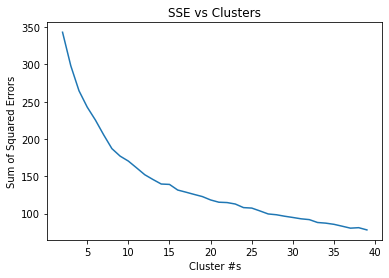

In [321]:
##Heart Disease
plotSSE(clusters, norm_hd)

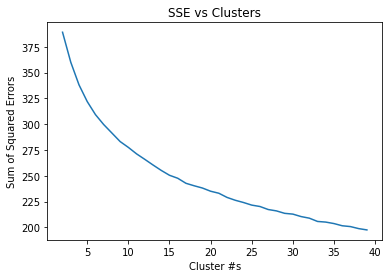

In [322]:
##Potable Water
plotSSE(clusters, norm_water)

In [339]:
##Cluster fit checks
scores_hd = getScores(norm_hd, hd_y)
print("heart disease scores: ", scores_hd)

heart disease scores:  [0.797979797979798, 0.2730960225839195]


In [324]:
scores_water = getScores(norm_water, water_y)
print("potable water scores: ", scores_water)

potable water scores:  [0.5129166666666667, 0.00018421222365803714]


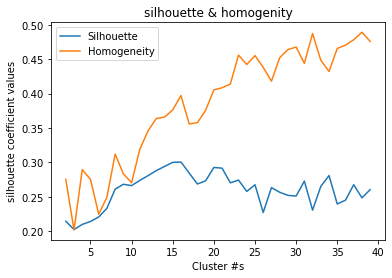

In [325]:
##Silhouette & homogenity Plotting for heart disease
plotSilhouette(norm_hd, hd_y, clusters)

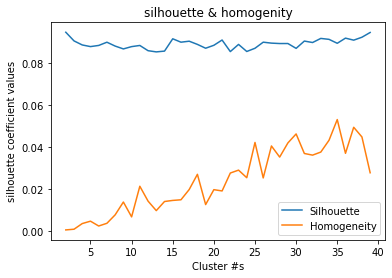

In [326]:
##Silhouette & homogenity Plotting for potable water
plotSilhouette(norm_water, water_y, clusters)

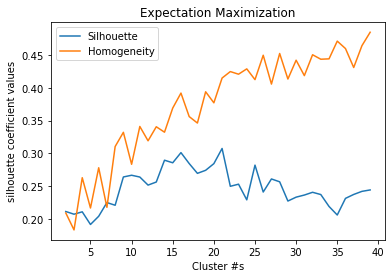

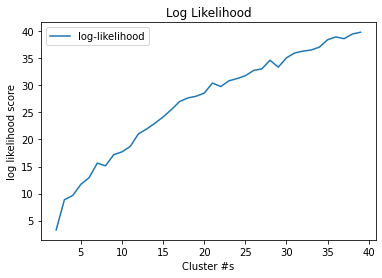

In [340]:
##Expectation Maximization heart disease
plotSilhouetteEM(norm_hd, hd_y, clusters)

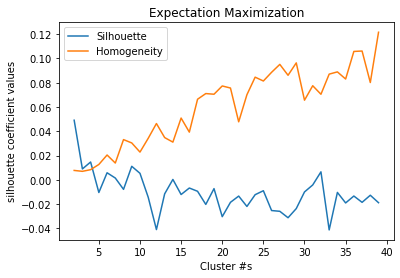

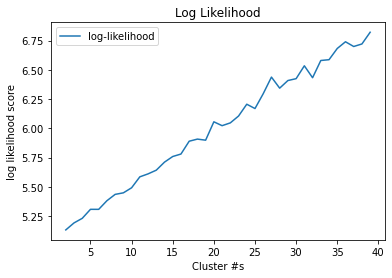

In [328]:
##Expectation Maximization potable water
plotSilhouetteEM(norm_water, water_y, clusters)

In [341]:
##GMM Accuracy
heart = gaussianAccuracy(norm_hd, hd_y)
water = gaussianAccuracy(norm_water, water_y)

print("Gaussian Accuracies for heart: ", heart)
print("Gaussian Accuracies for water: ", water)

Gaussian Accuracies for heart:  0.7643097643097643
Gaussian Accuracies for water:  0.55125


In [386]:
##KMeans Neural Network heart disease
kmeans_hd = KMeans(n_clusters=2, n_init=20, max_iter=1000, random_state=44).fit(norm_hd)
label_hd = 1-kmeans.labels_
kmeans_X_hd = label_hd.reshape(297,1)

from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(kmeans_X_hd, hd_y)

MLPClassifier()

In [387]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
hd_train_predictions = nn.predict(kmeans_X_hd)
acc = accuracy_score(hd_y, hd_train_predictions)
print(acc)
print(classification_report(hd_y, hd_train_predictions))

0.797979797979798
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       160
           1       0.77      0.81      0.79       137

    accuracy                           0.80       297
   macro avg       0.80      0.80      0.80       297
weighted avg       0.80      0.80      0.80       297



[learning_curve] Training set sizes: [  2   8  13  18  24  29  35  40  45  51  56  62  67  72  78  83  88  94
  99 105 110 115 121 126 132 137 142 148 153 159 164 169 175 180 186 191
 196 202 207 213 218 223 229 234 240 245 250 256 261 267]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    4.1s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    5.9s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    7.8s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:    9.7s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:   11.5s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:   13.3s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   15.1s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   16.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   18.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.5s finished


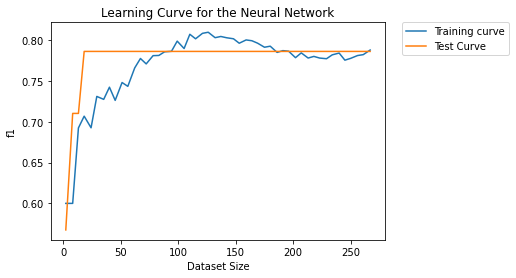

In [388]:
#learning Curve from Assignment 1
#best param = {'alpha': 0.2, 'hidden_layer_sizes': (50, 50)} #due to smaller sets of data
optimal_df = MLPClassifier(random_state=42, max_iter=2000, alpha=0.2, hidden_layer_sizes=(50,50))
train_sizes, train_scores, test_scores = learning_curve(optimal_df, kmeans_X_hd, hd_y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("f1")
plt.title("Learning Curve for the Neural Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   8  13  18  24  29  35  40  45  51  56  62  67  72  78  83  88  94
  99 105 110 115 121 126 132 137 142 148 153 159 164 169 175 180 186 191
 196 202 207 213 218 223 229 234 240 245 250 256 261 267]


[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    2.4s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    4.6s remaining:   20.0s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    6.7s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:    9.2s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:   12.1s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:   14.8s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   17.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   19.9s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   22.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.5s finished


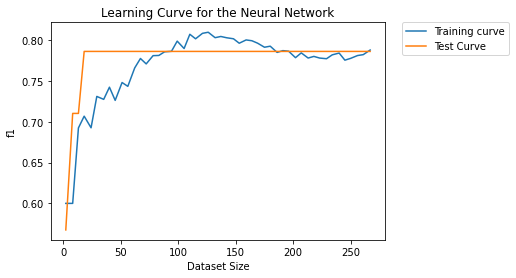

In [389]:
#best param = {'alpha': 0.2, 'hidden_layer_sizes': (50, 50)} #due to smaller sets of data
optimal_df = MLPClassifier(random_state=42, max_iter=2000, alpha=0.2, hidden_layer_sizes=(60,60))
train_sizes, train_scores, test_scores = learning_curve(optimal_df, kmeans_X_hd, hd_y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("f1")
plt.title("Learning Curve for the Neural Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   8  13  18  24  29  35  40  45  51  56  62  67  72  78  83  88  94
  99 105 110 115 121 126 132 137 142 148 153 159 164 169 175 180 186 191
 196 202 207 213 218 223 229 234 240 245 250 256 261 267]


[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    3.7s remaining:   40.2s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    7.9s remaining:   34.6s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:   12.2s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:   16.8s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:   20.8s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:   25.0s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   29.3s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   33.3s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   39.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.3s finished


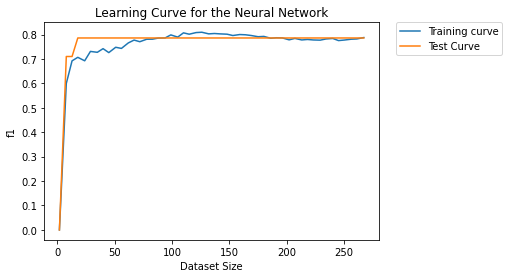

In [390]:
#best param = {'alpha': 0.2, 'hidden_layer_sizes': (100, 100)} #due to smaller sets of data
optimal_df = MLPClassifier(random_state=42, max_iter=2000, alpha=0.2, hidden_layer_sizes=(100,100))
train_sizes, train_scores, test_scores = learning_curve(optimal_df, kmeans_X_hd, hd_y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("f1")
plt.title("Learning Curve for the Neural Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [391]:
##EM Algorithm Neural Network heart disease
gmm_hd = GaussianMixture(n_components=2, n_init=20, max_iter=1000, random_state=44).fit(norm_hd)
gmm_label_hd = 1-gmm_hd.predict(norm_hd)
gmm_X_hd = gmm_label_hd.reshape(297,1)

nn_EM = MLPClassifier()
nn_EM.fit(gmm_X_hd, hd_y)

MLPClassifier()

[learning_curve] Training set sizes: [  2   8  13  18  24  29  35  40  45  51  56  62  67  72  78  83  88  94
  99 105 110 115 121 126 132 137 142 148 153 159 164 169 175 180 186 191
 196 202 207 213 218 223 229 234 240 245 250 256 261 267]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    2.1s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    5.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    8.7s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:   13.9s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:   19.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:   22.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   24.2s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   26.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   29.6s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.1s finished


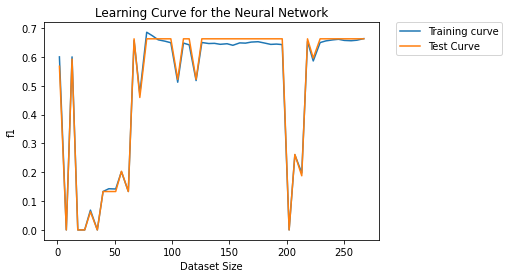

In [392]:
#learning Curve from Assignment 1
#best param = {'alpha': 0.2, 'hidden_layer_sizes': (50, 50)} #due to smaller sets of data
optimal_df = MLPClassifier(random_state=42, max_iter=2000, alpha=0.2, hidden_layer_sizes=(50,50))
train_sizes, train_scores, test_scores = learning_curve(optimal_df, gmm_X_hd, hd_y, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("f1")
plt.title("Learning Curve for the Neural Network")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)